In [87]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

In [88]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [89]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

Tarea 1 Calculo para ciencia de datos

Nombre:Vicente Ignacio Alvarez Zuñiga

Pregunta 2: El codigo de ejemplo calcula la distancia Euclidiana entre dos lugares en la Tierra. Sin embargo, es m´ as fidedigno usar una distancia geodesica para modelar el flujo de polvo en la atmosfera. La expresion Rarccos(sen(ϕ1)sen(ϕ2) + cos(ϕ1)cos(ϕ2)cos(λ2 − λ1)) mide la distancia entre dos puntos con latitud ϕ1 y ϕ2 y longitud λ1 y λ2 en la superficie de una esfera con radio R.

In [90]:
#definimos la distancia geodesica con la formula del enunciado
def distance_geodesic(x,y,radio=6371):
    lat1, lon1 = np.radians(x[0]), np.radians(x[1])
    lat2, lon2 = np.radians(y[0]), np.radians(y[1])
    sin_lat1 = np.sin(lat1)
    sin_lat2 = np.sin(lat2)
    cos_lat1 = np.cos(lat1)
    cos_lat2 = np.cos(lat2)
    cos_lon_diff = np.cos(lon2 - lon1)
    distance = np.arccos(sin_lat1 * sin_lat2 + cos_lat1 * cos_lat2 * cos_lon_diff) * radio
    return distance
#definimos la distancia euclideana
def distance_euclidean(x, y):
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

Pregunta 3: Implementen una funcion para calcular la distancia geodesica y apliquen el metodo de vecinos cercanos con esta distancia geodesica.

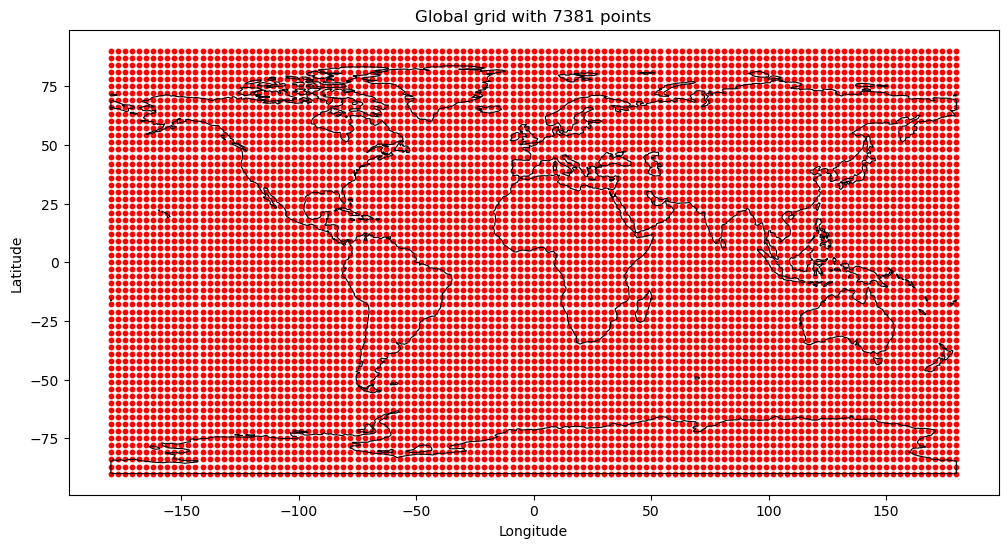

In [91]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

usamos la funcion dada en el ejemplo

In [92]:
def nearest_neighbour_estimation(df, x, k, dist):
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

calculamos con la geodesica

In [93]:
n_neighbours = 5
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

Pregunta 4:Visualizen el resultado con la distancia geodesica.

In [94]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


graficamos con la funcion dada en el ejemplo

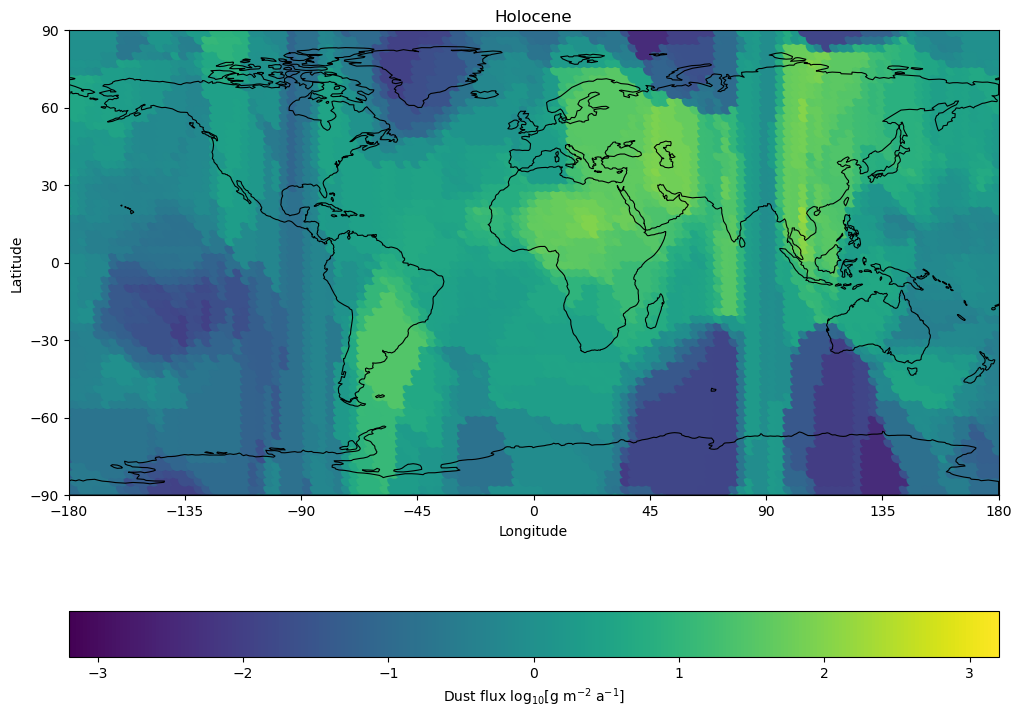

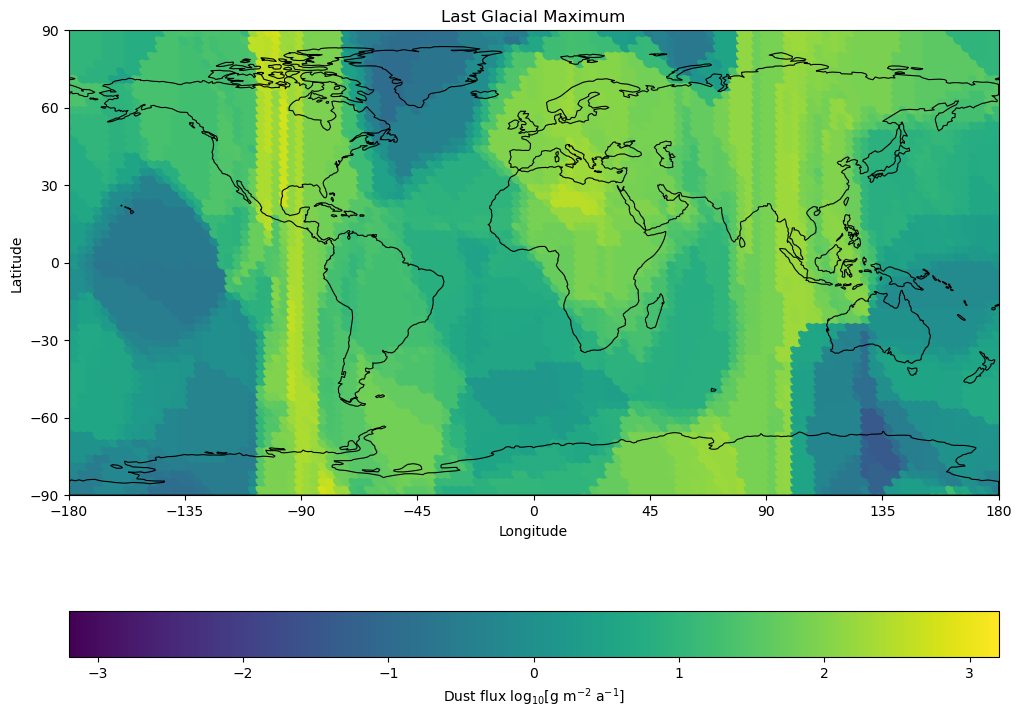

In [95]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_HOLOCENE',
                        label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_LGM',
                        label_str='est_lgm')

Pregunta 5: Calculen la diferencia entre los dos metodos (distancia Euclidiana y geodesica) y vizualizen esta diferencia.

In [96]:
df_global_grid.head()

,lon,lat,est_hol,est_lgm
0,-180.0,-90.0,-0.943857,0.336214
1,-177.0,-90.0,-0.943857,-0.531728
2,-174.0,-90.0,-0.611015,-0.531728
3,-171.0,-90.0,-0.611015,-0.531728
4,-168.0,-90.0,-0.611015,-0.271522


In [97]:
n_neighbours = 5
estimation_holocene = np.repeat(np.inf, len(df_global_grid))
estimation_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimation_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimation_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol_e"] = estimation_holocene
df_global_grid["est_lgm_e"] = estimation_lgm

calculamos la diferencia


In [98]:
df_global_grid['dist_difference'] = df_global_grid['est_hol_e'] + df_global_grid['est_hol_e'] -(df_global_grid['est_hol'] + df_global_grid['est_hol'])


ahora la graficamos

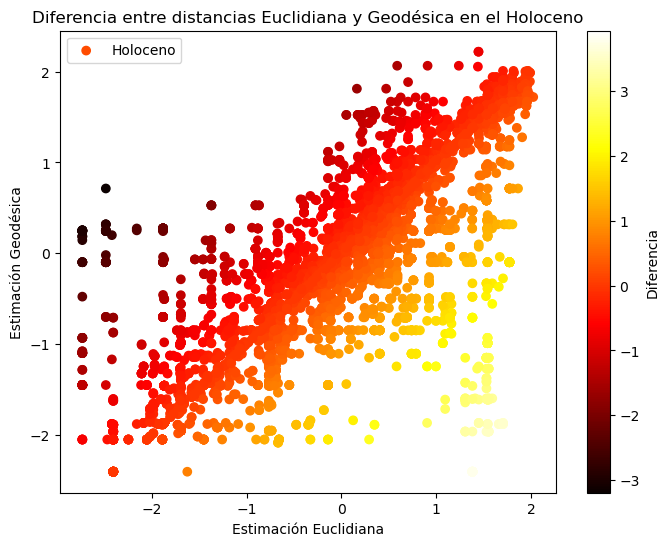

In [99]:
#El siguente codigo es sacado con ayuda de chat gpt
df_global_grid['dist_difference_hol'] = df_global_grid['est_hol_e'] - df_global_grid['est_hol']
plt.figure(figsize=(8, 6))
scatter_hol = plt.scatter(df_global_grid['est_hol_e'], df_global_grid['est_hol'], c=df_global_grid['dist_difference_hol'], cmap='hot', label='Holoceno')
plt.colorbar(scatter_hol, label='Diferencia')
plt.xlabel('Estimación Euclidiana')
plt.ylabel('Estimación Geodésica')
plt.title('Diferencia entre distancias Euclidiana y Geodésica en el Holoceno')
plt.legend()
plt.show()


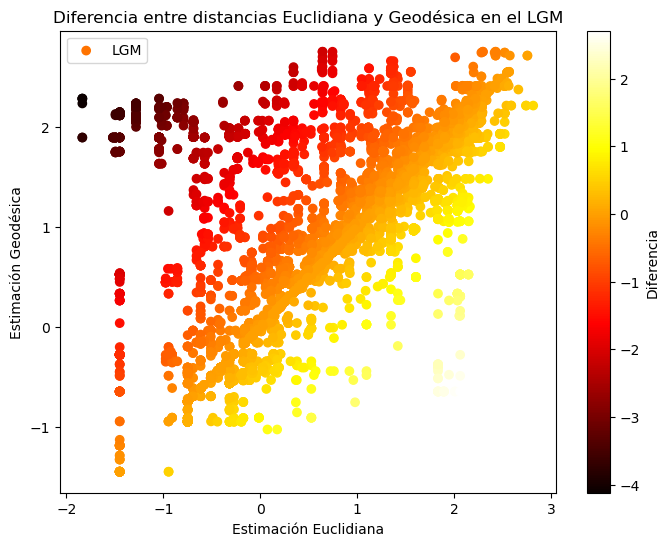

In [100]:
#El siguiente codigo lo saque con ayuda de chat gpt
df_global_grid['dist_difference_lgm'] = df_global_grid['est_lgm_e'] - df_global_grid['est_lgm']

plt.figure(figsize=(8, 6))
scatter_lgm = plt.scatter(df_global_grid['est_lgm_e'], df_global_grid['est_lgm'], c=df_global_grid['dist_difference_lgm'], cmap='hot', label='LGM')
plt.colorbar(scatter_lgm, label='Diferencia')
plt.xlabel('Estimación Euclidiana')
plt.ylabel('Estimación Geodésica')
plt.title('Diferencia entre distancias Euclidiana y Geodésica en el LGM')
plt.legend()
plt.show()


Pregunta 6:Discuten por que los resultados son distintos. En sus respuestas, a me nos incluyen una discusion sobre los temas siguientes. a) ¿Por que las diferencias son mas grandes en una parte que otra parte del mundo? b) ¿Cual metodo es mas fidedigno en los polos sur y norte? c) ¿Cual metodo es mas fidedigno en longitud 180◦? d) ¿Cuales son las diferencias entre los resultados para el Holoceno y el LGM? e) ¿Como elegir el numero de vecinos cercanos?

a) Las diferencias más grandes en diferentes partes del mundo se deben a la distribución desigual de puntos de muestreo y las características geográficas, como la topografía. Estas disparidades pueden influir en la precisión de las estimaciones de distancia en cada región.

b) En los polos sur y norte, la distancia geodésica es más fidedigna debido a que tiene en cuenta la forma curva de la Tierra. La convergencia de los meridianos en estas regiones puede causar distorsiones en la proyección plana de la distancia euclidiana.

c) En longitud 180°, la distancia euclidiana puede no ser precisa debido a que no refleja adecuadamente la verdadera distancia a lo largo de la línea del meridiano antimeridiano. La distancia geodésica, al considerar la curvatura de la Tierra, proporciona una estimación más precisa en esta región.

d) Las diferencias entre los resultados del Holoceno y el Último Máximo Glacial (LGM) se deben a cambios en el nivel del mar, la distribución de los glaciares y la configuración de la tierra. Durante el Holoceno, el clima era más cálido y había menos hielo, lo que afecta la topografía y la distribución del agua.

e) La elección del número de vecinos cercanos depende del equilibrio entre precisión y eficiencia computacional. Un mayor número de vecinos puede ofrecer estimaciones más precisas, pero también aumenta el tiempo de cálculo y la complejidad. Es importante evaluar el contexto y los objetivos del análisis para determinar el número óptimo de vecinos.